### custom dataset

In [ ]:
import torch
import torch.nn as nn
from PIL import Image

class CustomDataSet(torch.utils.Dataset):
    def __init__(self, img_list, label_list, transform):
        self.img_list= img_list
        self.label_list= label_list
        self.transform= transform

    def __len__(self):
        return len(self.img_list)
    
    def __getitem__(self, index):

        img_path = self.img_list[index]
        img = Image.open(img_path).convert('RGB')

        transfomred_img= self.transform(img)
        label= self.label_list[index]
        label_to_int = {'기쁨': 0, '당황': 1, '중립': 2, '불안':3}

        return transfomred_img, label

### transform, Dataloader

In [ ]:
import albumentations as A
from albumentations.pytorch import ToTensorV2 
from torch.utils.data import DataLoader


train_transforms = A.Compose([
    A.OneOf([
        A.HorizontalFlip(p=0.5),
    ], p=1.0),
    A.OneOf([
        A.RandomBrightnessContrast(p=0.5),
        A.RandomGamma(p=0.5),
        A.ColorJitter(p=0.5),
    ], p=1.0),
    A.OneOf([
        A.MotionBlur(p=0.2),
        A.MedianBlur(blur_limit=3, p=0.1),
        A.GaussianBlur(blur_limit=3, p=0.1),
        A.GaussNoise(p=0.2),
    ], p=1.0),
    A.OneOf([
        A.RandomRain(p=0.2),
        A.RandomSnow(p=0.2),
        A.RandomFog(p=0.2),
        A.RandomShadow(p=0.2),
    ], p=1.0),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2()
])

val_transforms = A.Compose([
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2()
])


train_dataset = CustomDataSet("C:/Users/chldy/Downloads/data/training_set/dogs", "C:/Users/USER/Desktop/resized_train_annotations", transforms=train_transforms)
val_dataset = CustomDataSet("C:/Users/chldy/Downloads/data/training_set/cats", "C:/Users/USER/Desktop/resized_valid_annotations", transforms=val_transforms)



In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
 
import PIL

import os
import time

In [2]:
dog_files = [f'dog.{i}.jpg' for i in range(100)]
cat_files = [f'cat.{i}.jpg' for i in range(100)]


In [3]:
import numpy as np
import torch
from PIL import Image

class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, files, root, mode='train', transform=None):
        self.files = files
        self.root = root
        self.mode = mode
        self.transform=transform
        
        if 'cat' in files[0]:
            self.label = 0
        else:
            self.label = 1
    
    def __len__(self):
        return len(self.files)
    
    def __getitem__(self, index):
        img = PIL.Image.open(os.path.join(self.root, self.files[index]))
        
        if self.transform:
            img = self.transform(img)
        if self.mode == 'train':
            return img, np.array([self.label])
        else:
            return img, self.files[index]

In [4]:
train_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize((256,256)),
    torchvision.transforms.RandomCrop(224),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.ToTensor(),
])
test_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize((224,244)),
    torchvision.transforms.ToTensor(),
])

In [5]:
train_dog_dataset = CustomDataset(dog_files[:100], "C:/Users/chldy/Downloads/data/training_set/dogs", transform=train_transform)
train_cat_dataset = CustomDataset(cat_files[:100], "C:/Users/chldy/Downloads/data/training_set/cats", transform=train_transform)
valid_dog_dataset = CustomDataset(dog_files[:100], "C:/Users/chldy/Downloads/data/test_set/dogs", transform=test_transform)
valid_cat_dataset = CustomDataset(cat_files[:100], "C:/Users/chldy/Downloads/data/test_set/cats", transform=test_transform)

 
train_dataset = torch.utils.data.ConcatDataset([train_dog_dataset, train_cat_dataset])
valid_dataset = torch.utils.data.ConcatDataset([valid_dog_dataset, valid_cat_dataset])


print(f'number of train dataset : {len(train_dataset)}')
print(f'number of valid dataset : {len(valid_dataset)}')


number of train dataset : 200
number of valid dataset : 200


In [6]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=32, shuffle=True)

In [7]:
Device='cuda' if torch.cuda.is_available() else 'cpu'
print(Device)

cuda


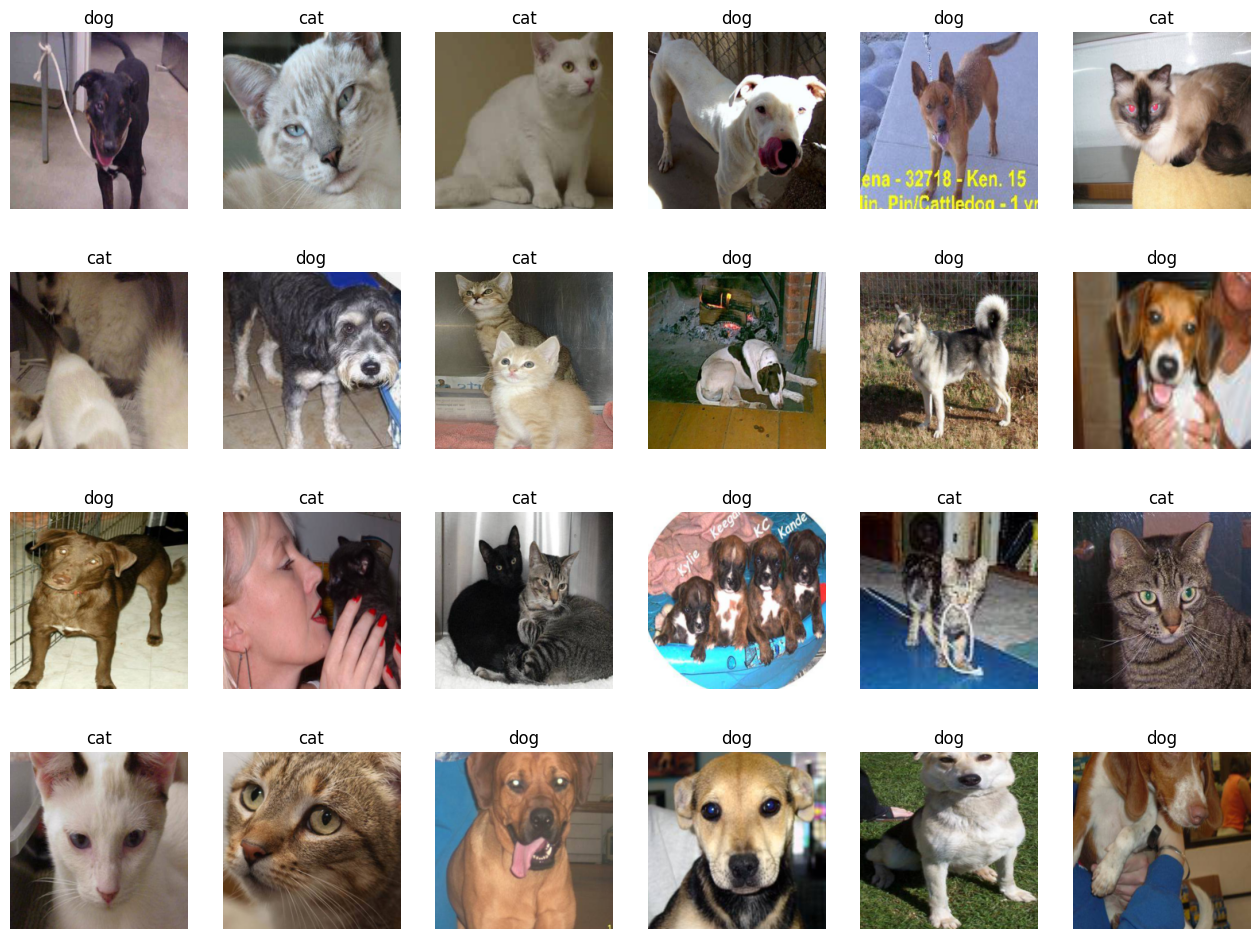

In [10]:
samples, labels = images, labels = next(iter(train_loader))

classes = {0:'cat', 1:'dog'}
fig = plt.figure(figsize=(16,24))
for i in range(24):
    a = fig.add_subplot(4,6,i+1)
    a.set_title(classes[labels[i].item()])
    a.axis('off')
    a.imshow(np.transpose(samples[i].numpy(), (1,2,0)))
plt.subplots_adjust(bottom=0.2, top=0.6, hspace=0)

In [ ]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        # conv1 = input 3, output 8 channels, kernel 3, padding 1 224 224 3 
        self.conv1 = nn.Conv2d(in_channels = 3, out_channels = 8, kernel_size = 3, padding = 1) #input channel 3, kernel의 개수 8개
        # conv2 = input 8, output 16 channels, kernel 3, padding 1 
        self.conv2 = nn.Conv2d(in_channels = 8, out_channels = 16, kernel_size=3, padding=1)#input channel 8, kernel의 개수 16개
        # pool = kernel 2, stride 2
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        # fc layer 3 = input, 64, 32, 10
        self.fc1 = nn.Linear(8 * 8 * 16, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 10)
        
    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.pool(x)
        x = x.view(-1, 8 * 8 * 16) #1차원으로 flatten
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        x = F.log_softmax(x)
        return x

In [13]:
model = CNN().to(Device)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
criterion = nn.CrossEntropyLoss()

print(model)

CNN(
  (conv1): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1024, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=10, bias=True)
)


In [14]:
def train(model, train_loader, optimizer, log_interval):
    model.train()
    for batch_idx, (image, label) in enumerate(train_loader):
        image = image.to(Device)
        label = label.to(Device)
        optimizer.zero_grad()
        output = model(image)
        loss = criterion(output, label)
        loss.backward()
        optimizer.step()

        if batch_idx % log_interval == 0:
            print("Train Epoch: {} [{}/{} ({:.0f}%)]\tTrain Loss: {:.6f}".format(
                epoch, batch_idx * len(image), 
                len(train_loader.dataset), 100. * batch_idx / len(train_loader), 
                loss.item()))

In [15]:
def evaluate(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0

    with torch.no_grad():
        for image, label in test_loader:
            image = image.to(Device)
            label = label.to(Device)
            output = model(image)
            test_loss += criterion(output, label).item()
            prediction = output.max(1, keepdim = True)[1]
            correct += prediction.eq(label.view_as(prediction)).sum().item()
    
    test_loss /= len(test_loader.dataset)
    test_accuracy = 100. * correct / len(test_loader.dataset)
    return test_loss, test_accuracy

In [17]:
EPOCHS=10

In [18]:
for epoch in range(1, EPOCHS + 1):
    train(model, train_loader, optimizer, log_interval = 200)
    test_loss, test_accuracy = evaluate(model, valid_loader)
    print("\n[EPOCH: {}], \tTest Loss: {:.4f}, \tTest Accuracy: {:.2f} % \n".format(
        epoch, test_loss, test_accuracy))

C:\Users\chldy\AppData\Local\Temp\ipykernel_6056\169340843.py:28: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.log_softmax(x)


ValueError: Expected input batch_size (1568) to match target batch_size (32).